### Подготовительный этап.

In [0]:
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
import osmnx as ox
import networkx as nx
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import csv
import json # пока писать будет в json, но если что переделаем

Выгрузим граф Уфы с помощью библиотеки osmnx

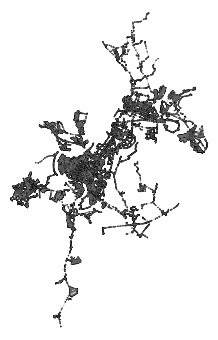

In [0]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

fig, ax = ox.plot_graph(G, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

In [0]:
# создадим список всех точек графа
nodes_list = list(G.nodes()) 

In [0]:
# пишем узлы в csv
nodes_df = pd.DataFrame(nodes_list)
nodes_df.to_csv('nodes.csv', index=False)

По-хорошему, тут нужно создать матрицу и лист смежности


In [0]:
# нахождение расстояний между смежными узлами 
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [0]:
# пишем список смежности в csv
adj_list = nx.generate_adjlist(G, delimiter=' ')
with open('adjacency_list.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=' ')
    for line in adj_list:
        writer.writerow(line)

In [0]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
G_pd.to_csv('matrix_adjacency_pandas.csv')

In [0]:
# переводив в нампаевский ndarray
# !запускать только один раз!
G_pd = G_pd.values

In [0]:
print(G_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

Штука внизу не работает, потому что мы дикты создаем только ниже (Оксана)


---

Соре не использовала ее, можно потом пониже поместить

In [0]:
# вместо нулей и единиц записываем в матрицу смежности расстояния между нодами (по формуле из файла)
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# если ребра между нодами нет, то заполняем большими расстояниями (для нахождения крастчайших путей)
# возможно, можно придумать что-то менее костыльное
        if G_pd[i][j] == 0:
            G_pd[i][j] = 10**10

Выбираем M больниц и N домов

In [0]:
# вытаскиваем все больницы и дома

buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

hospitals = []
apartments = []
build = buildings['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospitals.append(key)
    elif value == 'apartments':
        apartments.append(key)


In [0]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node

In [0]:
# оставим только уникальные значения G
temp = hospitals_dict.copy()
hospitals_dict = {}

for key, value in temp.items():
  if value not in hospitals_dict.values():
    hospitals_dict[key] = value

temp = apartments_dict.copy()
apartments_dict = {}

for key, value in temp.items():
  if (value not in apartments_dict.values()) and (value not in hospitals_dict.values()):
    apartments_dict[key] = value

In [0]:
M = 10
N = 100

hospitals_dict = dict(random.sample(list(hospitals_dict.items()), M))
apartments_dict = dict(random.sample(list(apartments_dict.items()), N))

Создадим несколько структур данных для работы впоследствии

In [0]:
# Создаем словарь {id узла}: {его index в списке узлов} 
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [0]:
# делаем листы для использования Дейсктры 
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [0]:
# создаем общий лист, чтобы сделать и дома, и больницы одновременно
new_nodes = apartments_values + hospital_values
new_nodes = np.array(new_nodes)

In [0]:
# матрица в которой будем хранить значения кратчайших путей
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

In [0]:
'''
nodes_list - лист со всеми точками графа G
nodes_numbers - {id узла}: {его index в списке узлов}

hospitals_dict, apartments_dict - словари, ключ - точка из footsprint, значение - точка G
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())
new_nodes = apartments_values + hospital_values

'''

Дейкстра, использующая кучу

In [0]:
from heapq import heappush, heappop

def dijkstra_heap (G, source):
    
    G_succ = G._succ 

    push = heappush
    pop = heappop
    weight = lambda d: min(attr.get(weight, 1) for attr in d.values()) #понятия не имею что происходит в этой строчке увы

    seen = {}  # минимальное расстояние до ключа-точки  
    tree = {}
    # fringe is heapq with 2-tuples (distance,node)
    fringe = []

    seen[source] = 0
    push(fringe, (0, source, None))

    while fringe:

        (d, v, pred) = pop(fringe)

        if v in tree:
            continue  # already searched this node.

        tree[v] = {}
        tree[v]['node'] = v
        tree[v]['dist'] = d
      
        if pred != None:

          if len(tree[pred]['path']) > 0:
            tree[v]['path'] = (tree[pred]['path']).copy()
            tree[v]['path'].append(pred)      
          else:
            tree[v]['path'] = [pred]
        else:
          tree[source]['path'] = []

        for u, e in G_succ[v].items():
            cost = weight(e) #e - ребро (мультиграф же,значит их несколько, выбираем наименьший вес)

            if cost is None: # видимо если ребра нет, возможно стоит заменить на бесконечное значение
                continue

            vu_dist = tree[v]['dist'] + cost
             
            if u not in seen or vu_dist < seen[u]: #если мы еще не искали путь до u или новое расстояние меньше найденного              
                seen[u] = vu_dist
                push(fringe, (vu_dist, u, v))
    return tree

Запуск Дейкстры



In [0]:
import time

big_tree_dict = {}
start = time.time()

for i in range(len(new_nodes)):
    tree = dijkstra_heap(G, new_nodes[i])
    big_tree_dict[new_nodes[i]] = tree

print(time.time() - start)

56.2133891582489


Это дерево еще понадобится, так что я бы его куда-нибудь тоже скачала (хотя оно большое)

---
Я вроде записала (Оксана)
У меня оно съедает всю RAM
постарюсь что-то придумать другое

In [0]:
with open('big_tree.csv', 'w') as f:
    for key in big_tree_dict.keys():
        f.write("%s,%s\n"%(key, big_tree_dict[key]))

KeyboardInterrupt: ignored

Уменьшаем дерево до точек N+M

In [0]:
# удалим ненужные точки сделав из большого дерева кратчайших путей малое дерево мощности N+M

small_tree_dict = big_tree_dict.copy()

for tree_key, tree in big_tree_dict.items():

  keys = list(tree.keys())
  small_tree = tree.copy()
  for child in tree.keys():
    small_tree[child] =  small_tree[child].copy()

  for key in keys:
    if key not in new_nodes:
      del small_tree[key]
  
  keys = list(small_tree.keys())

  for key in keys:
    small_tree[key]['path'] =  small_tree[key]['path'].copy()

  for key in keys:
    temp = small_tree[key]['path'].copy()
    for el in temp:
      if el not in new_nodes:
        small_tree[key]['path'].remove(el)

  small_tree_dict[tree_key] = small_tree

In [0]:
print(small_tree_dict)

{1065657767: {1065657767: {'node': 1065657767, 'dist': 0, 'path': []}, 1331965064: {'node': 1331965064, 'dist': 11, 'path': [1065657767]}, 3700686091: {'node': 3700686091, 'dist': 18, 'path': [1065657767]}, 1141854647: {'node': 1141854647, 'dist': 23, 'path': [1065657767]}, 1152635200: {'node': 1152635200, 'dist': 24, 'path': [1065657767]}, 1065658060: {'node': 1065658060, 'dist': 27, 'path': [1065657767]}, 1385659908: {'node': 1385659908, 'dist': 27, 'path': [1065657767, 3700686091]}, 1812414128: {'node': 1812414128, 'dist': 29, 'path': [1065657767, 1141854647]}, 1156237154: {'node': 1156237154, 'dist': 31, 'path': [1065657767]}, 1156237160: {'node': 1156237160, 'dist': 32, 'path': [1065657767]}, 1118418017: {'node': 1118418017, 'dist': 33, 'path': [1065657767]}, 1437631889: {'node': 1437631889, 'dist': 35, 'path': [1065657767]}, 4368530169: {'node': 4368530169, 'dist': 35, 'path': [1065657767]}, 423194712: {'node': 423194712, 'dist': 36, 'path': [1065657767]}, 759566822: {'node': 759

Матрица кратчайших путей для N+M точек

In [0]:
  for i in range(N+M):  
    tree = small_tree_dict[new_nodes[i]]
    for j in range(N+M): 
      if new_nodes[j] in tree:
        short_path_matrix[i][j] = tree[new_nodes[j]]['dist']   
      else: 
        short_path_matrix[i][j] = 0  

In [0]:
 short_path_matrix

array([[  0., 162.,  57., ..., 130., 265., 163.],
       [171.,   0., 204., ..., 134., 183.,  11.],
       [ 57., 195.,   0., ..., 158., 298., 196.],
       ...,
       [126., 124., 151., ...,   0., 275., 125.],
       [292., 182., 325., ..., 290.,   0., 193.],
       [172.,  11., 205., ..., 135., 194.,   0.]])

In [0]:
# записываем матрицу кратчайших путей в csv
with open('matrix_dijkstra.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in short_path_matrix:
        writer.writerow(line)

In [0]:
# ставим вместо 0 - 10**10
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0:
            short_path_matrix[i][j] = 10**10

Создадим лист смежности дерева для более удобного взаимодействия

In [0]:
small_tree_dict_adj = {}

# беру пути до каждой точки и из них дерево в формате вершина: (ребенок, длина ребра)
for root, tree in  small_tree_dict.items():

  seen = {}
  new_tree = {}

  for node in tree:
    new_tree[node] = []

  for node in tree:

    if node in seen:
      continue

    seen[node] = 1
    #path = tree[node]['path']
    path = tree[node]['path']

    for i in range(1,len(path)):
      if path[i] in seen:
        continue
      seen[path[i]] = 1
      new_tree[path[i-1]].append((path[i], tree[path[i-1]]['dist'] - tree[path[i]]['dist']))

    if(len(path) > 0):
      new_tree[path[len(path) - 1]].append((node, tree[node]['dist'] - tree[path[len(path) - 1]]['dist']))

    small_tree_dict_adj[root] = new_tree

In [0]:
# пишем в csv лист смежности дерева
with open('small_tree_adj_list.csv', 'w') as f:
    for key in small_tree_dict_adj.keys():
        f.write("%s,%s\n"%(key, small_tree_dict_adj[key]))

Матрицы смежности для разных узлов

In [0]:
# сделать матрицу смежности из получившихся деревьев
def make_adj_m (tree, nodes):
  adjancecy_m = np.zeros((110, 110))
  for node in nodes:
    for child, dlina in tree[node]:
      adjancecy_m[np.where(nodes == node)[0][0]][np.where(nodes == child)[0][0]] = dlina
  return adjancecy_m

In [0]:
# можно сделать и скачать все матрицы смежности

adjancecy_m_dict = {}

for node in new_nodes:
  tree = small_tree_dict_adj[node]
  adjancecy_m = make_adj_m (tree, new_nodes)
  adjancecy_m_dict[node] = adjancecy_m.copy()
  adjancecy_m_pd = pd.DataFrame(data = adjancecy_m, index = new_nodes, columns = new_nodes)
  #adjancecy_m_pd.to_csv('adjancecy_m_'+str(new_nodes[100])) #не хочу качать сейчас


**Визуализация** дерева кратчайших путей для первой точки new_nodes

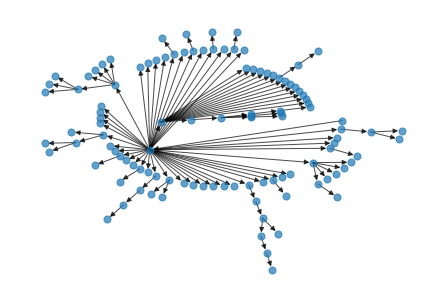

In [0]:
small_adjancecy = adjancecy_m_dict[new_nodes[0]]

new_G = nx.from_numpy_matrix(small_adjancecy, create_using = nx.DiGraph)

# рисую граф
from networkx.drawing.nx_pydot import graphviz_layout
pos = graphviz_layout(new_G, prog='twopi')
nx.draw(new_G, pos, node_size = 50, alpha = 0.7)

Нам нужен json?

---
Ну прост дерево выглядит нагляднее в json, чем в csv. Но если мы можем красиво записать в csv, то не нужен. **ЕЩЕ ВАЖНО** предлагаю как-нибудь скачать картинки деревьев в png/jpeg/etс, так удобнее будет показывать имхо (Оксана)

Согласна!


In [0]:
 #пишем в json файл дерево кратчайших путей
 with open('short_path_tree.json', 'w') as f:
     json.dump(tree_dict, f)

In [0]:
 with open('short_path_tree.json', 'r') as fr:
     head = [next(fr) for _ in range(20)]
     print(head)

In [0]:
# пишем в json все кратчайшие пути
with open('short_paths.json', 'w') as f:
    json.dump(short_paths, f)

А это?

---
Если в твоих функциях дальше нигде не используется, то не нужно (Оксана)


In [0]:
# получение ключа 
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

# получение айди
def get_id(nodes_numbers, index_nodes, i):
    temp = get_key(nodes_numbers, index_nodes[i])
    if temp == -1:
        return "Не найдено id узла"
    else:
        return temp

Всякое разное (понадобится далее)

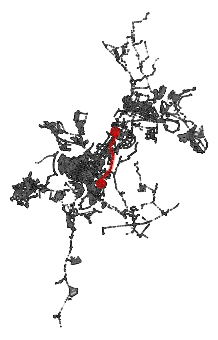

(<Figure size 468.322x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f08d1980cc0>)

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
route = nx.shortest_path(G,
                         892683760,
                         498826321, 
                         weight='length') 

ox.plot_graph_route(G, route, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

Нижняя шляпа не работает, но я подумаю как ее поправить

### Первое задание.

In [0]:
#from numpy import genfromtxt
# считываем матрицу кратчайших расстояний из csv файла
# data = genfromtxt('/content/matrix_dijkstra.csv', delimiter=',') 

# можно загрузить эту матрицу если она есть в оперативке
data = short_path_matrix

### Пункт 1.а 
Для каждого дома определить ближайший от узла объект (путь “туда”), ближайший к объекту узел (путь “обратно”), объект, расстояние до которого и обратно минимально (“туда и обратно”).

In [0]:
# функция нахождения ближайшей больницы
def find_nearest_hospitals(dist_matrix, apart_count=100):
    nearest_hosp_list = [[-1 for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        nearest_hosp_list[i][0] = np.argmin(dist_matrix[i][apart_count:]) + apart_count
        nearest_hosp_list[i][1] = np.argmin(np.array(dist_matrix[apart_count:]).transpose()[i]) + apart_count
        tuda = dist_matrix[i][apart_count:]
        suda = np.array(dist_matrix[apart_count:]).transpose()[i]
        nearest_hosp_list[i][2] = np.argmin(tuda + suda) + apart_count
    return nearest_hosp_list


In [0]:
# запуск программы
find_nearest_hospitals(data)

[[101, 101, 101],
 [109, 109, 109],
 [105, 105, 105],
 [106, 103, 106],
 [107, 107, 107],
 [105, 105, 105],
 [101, 101, 101],
 [105, 105, 105],
 [103, 103, 103],
 [103, 103, 103],
 [101, 101, 101],
 [100, 100, 100],
 [101, 101, 101],
 [100, 100, 100],
 [104, 104, 104],
 [101, 101, 101],
 [109, 109, 109],
 [104, 104, 104],
 [107, 107, 107],
 [103, 103, 103],
 [100, 100, 100],
 [103, 103, 103],
 [109, 109, 109],
 [100, 100, 100],
 [101, 101, 101],
 [100, 100, 100],
 [100, 100, 100],
 [109, 109, 109],
 [104, 104, 104],
 [103, 103, 103],
 [107, 107, 107],
 [103, 106, 103],
 [103, 103, 103],
 [103, 108, 108],
 [103, 103, 103],
 [101, 101, 101],
 [100, 100, 100],
 [108, 108, 108],
 [101, 101, 101],
 [106, 106, 106],
 [104, 104, 104],
 [103, 103, 103],
 [100, 100, 100],
 [107, 107, 107],
 [100, 100, 100],
 [100, 100, 100],
 [103, 103, 103],
 [103, 103, 103],
 [107, 107, 107],
 [108, 108, 108],
 [107, 107, 107],
 [100, 100, 100],
 [101, 101, 101],
 [100, 100, 100],
 [103, 103, 103],
 [103, 103

In [0]:
nearest_hosp_list = [[0 for i in range(3)] for j in range(M)]
temp = short_path_matrix.copy()
for i in range(M+N):
  if new_nodes[i] in apartments_dict:
    for j in range(M+N):
      if new_nodes[j] in apartments_dict:
        temp[i][j] = 10**10

for i in range(M):
  node = apartments_values[i]
  index = np.where(new_nodes == node)
  # туда
  nearest_hosp_list[i][0] = new_nodes[np.reshape(temp[index][:], 110).argmin()]
  # обратно
  nearest_hosp_list[i][1] = new_nodes[np.reshape(temp[:][index], 110).argmin()]
  #туда и обратно
  nearest_hosp_list[i][2] = new_nodes[(np.reshape(temp[index][:], 110) + 
                              np.reshape(temp[:][index], 110)).argmin()]
                              

In [0]:
nearest_hosp_list

[[1210430326, 1210430326, 1210430326],
 [1210430326, 1210430326, 1210430326],
 [5772685663, 5772685663, 5772685663],
 [1434079174, 1434079174, 1434079174],
 [2166452916, 2166452916, 2166452916],
 [250587314, 250587314, 250587314],
 [1028388462, 1028388462, 1028388462],
 [5848189431, 5848189431, 5848189431],
 [1373485302, 1373485302, 1373485302],
 [1028388656, 1028388656, 1028388656]]

In [0]:
route = big_tree_dict[apartments_values[2]][nearest_hosp_list[2][0]]['path']

In [0]:
route

[3448891640, 3448891641, 3448891642, 3448891645, 3218536543]

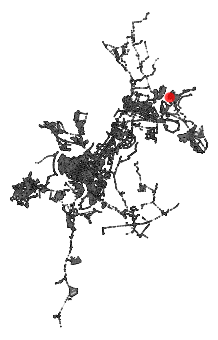

(<Figure size 468.322x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f08d4173128>)

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
ox.plot_graph_route(G, route, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

### Пункт 1.b
Для каждого дома определить объекты, расположенные не далее, чем в X км для каждого из трех вариантов “туда”, “обратно”, “туда и обратно”.

In [0]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов: "туда", "обратно" и "туда и обратно" 
# содержат своё количество индексов - это списки второго уровня,индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. 
def find_in_radius(dist_matrix, radius, apart_count=100):
    permissible_hosps = [[[] for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        for j in range(apart_count, len(dist_matrix)):
            if dist_matrix[i][j] <= radius:
                permissible_hosps[i][0].append(j)
            if dist_matrix[j][i] <= radius:
                permissible_hosps[i][1].append(j)
            if dist_matrix[i][j] + dist_matrix[j][i] <= radius:
                permissible_hosps[i][2].append(j)
    return permissible_hosps

In [0]:
# запуск программы, radius произвольный
radius = 500
find_in_radius(temp, radius)

[[[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]],
 [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]],
 [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]],
 [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 102, 103, 104, 106, 107, 108, 109]],
 [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 102, 103, 104, 106, 107, 108, 109]],
 [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]],
 [[100, 101, 102, 103, 104, 105, 106, 107,

### Пункт 2
Определить, какой из объектов расположен так, что расстояние между ним и самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [0]:
# возвращаемый список содержит три больницы - [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals(dist_matrix, apart_count=100):
    optimal_hosps = []
    tuda = np.array(dist_matrix[:apart_count]).transpose()[apart_count:]
    optimal_hosps.append(np.argmin(np.amax(tuda, 1)) + apart_count)
    suda = np.array(dist_matrix[apart_count:])[:, :apart_count]
    optimal_hosps.append(np.argmin(np.amax(suda, 1)) + apart_count)
    tuda_suda = tuda + suda
    optimal_hosps.append(np.argmin(np.amax(tuda_suda, 1)) + apart_count)
    return optimal_hosps

In [0]:
# запуск программы
opt = get_optimal_hospitals(temp)
print(opt)

[100, 100, 100]


### Пункт 3

Определить, для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна.

In [0]:
index_nodes = [] # индексы узлов домов
for i in new_nodes:
    index_nodes.append(nodes_numbers[i])

In [0]:
# возвращает id больницы
def min_sum_hosp(dist_matrix, apart_count=100):
    dist_sums = np.array(dist_matrix[apart_count:])[:, :apart_count]
    dist_sums = np.sum(dist_sums, 1)
    min_hosp = np.argmin(dist_sums) + apart_count
    hosp_id = get_id(nodes_numbers, index_nodes, min_hosp)
    return hosp_id

In [0]:
# запуск программы
min_hosp_id = min_sum_hosp(temp)
print(min_hosp_id)

2661495390


### Пункт 4
Определить, для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.

In [0]:
from heapq import heappush, heappop

def dijkstra_heap_value(G, source):
    
    G_succ = G._succ 

    push = heappush
    pop = heappop
    weight = lambda d: min(attr.get(weight, 1) for attr in d.values()) #понятия не имею что происходит в этой строчке увы

    seen = {}  # минимальное расстояние до ключа-точки  
    tree = {}
    # fringe is heapq with 2-tuples (distance,node)
    fringe = []

    seen[source] = 0
    push(fringe, (0, source, None))

    while fringe:

        (d, v, pred) = pop(fringe)

        if v in tree:
            continue  # already searched this node.

        tree[v] = {}
        tree[v]['node'] = v
        tree[v]['dist'] = d
      
        if pred != None:

          if len(tree[pred]['path']) > 0:
            tree[v]['path'] = (tree[pred]['path']).copy()
            tree[v]['path'].append(pred)      
          else:
            tree[v]['path'] = [pred]
        else:
          tree[source]['path'] = []

        for u, e in G_succ[v].items():
            cost = weight(e) #e - ребро (мультиграф же,значит их несколько, выбираем наименьший вес)

            if cost is None: # видимо если ребра нет, возможно стоит заменить на бесконечное значение
                continue

            vu_dist = tree[v]['dist'] + cost
             
            if u not in seen or vu_dist < seen[u]: #если мы еще не искали путь до u или новое расстояние меньше найденного              
                seen[u] = vu_dist
                push(fringe, (vu_dist, u, v))
    return tree, vu_dist

ЗДЕСЬ НУЖНО, ЧТОБЫ ПРОХОДИЛИ ТОЛЬКО ПО НАШИМ ТОЧКАМ

In [0]:
distances_from_hospitals = np.empty(len(hospital_values))
min_hospital_id = 0
min_value = 10**10

for i in range(len(hospital_values)):
  tree_hosp, distances_from_hospitals[i] = dijkstra_heap_value(G, hospital_values[i])
  if min_value > distances_from_hospitals[i]:
    min_value = distances_from_hospitals[i]
    min_hospital_id = hospital_values[i]

In [136]:
print("Min tree:", min_value)
print("Hospital id:",  min_hospital_id)

Min tree: 336.0
Hospital id: 2334187973


### Второе задание.
На карте случайным образом выбраны N узлов (домов) и один из объектов инфраструктуры.

### Пункт 1
Построить дерево кратчайших путей от объекта до выбранных узлов. Вычислить общую длину дерева, а также сумму кратчайших расстояний от объекта до всех заданных узлов.

In [0]:
choosen_hospital = {}
# просто выбираем рандомную больницу из hospitals_dict (я выбрала третью)
choosen_hospital = {89665061: 7512139535}

In [0]:
tree_choosen = {}
index = 7512139535
tree_choosen = dijkstra_heap(G, index)

ТОЧНО ТАКЖЕ НУЖНО УБРАТЬ ЛИШНИЕ ВЕРШИНЫ

### Пункт 2
Разбить выбранные узлы на кластеры, используя метод полной связи (сomplete-linkage clustering). Построить дендрограмму разбиения узлов.

In [0]:
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette

In [0]:
path_matrix = np.empty([len(apartments_values), len(apartments_values)])
for i in range(len(apartments_values)):
  for j in range(len(apartments_values)):
    path_matrix[i][j] = nx.dijkstra_path_length(G, apartments_values[i], apartments_values[j])

In [0]:
path_matrix

array([[  0.,  97.,  93., ..., 231.,  53., 120.],
       [108.,   0.,   6., ..., 146., 145.,  32.],
       [108.,   6.,   0., ..., 146., 145.,  32.],
       ...,
       [249., 148., 148., ...,   0., 277., 127.],
       [ 36., 133., 129., ..., 267.,   0., 156.],
       [133.,  32.,  32., ..., 125., 170.,   0.]])

In [142]:
# new_nodes
our_clusters = linkage(path_matrix, method='complete')
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
print(our_clusters)

[[2.60000000e+01 3.70000000e+01 4.47213595e+00 2.00000000e+00]
 [2.90000000e+01 7.40000000e+01 7.21110255e+00 2.00000000e+00]
 [2.50000000e+01 3.40000000e+01 9.84885780e+00 2.00000000e+00]
 [5.20000000e+01 7.80000000e+01 9.89949494e+00 2.00000000e+00]
 [7.00000000e+00 8.60000000e+01 1.00000000e+01 2.00000000e+00]
 [1.50000000e+01 5.00000000e+01 1.00000000e+01 2.00000000e+00]
 [1.80000000e+01 4.90000000e+01 1.00000000e+01 2.00000000e+00]
 [2.30000000e+01 6.80000000e+01 1.00000000e+01 2.00000000e+00]
 [2.40000000e+01 7.70000000e+01 1.00000000e+01 2.00000000e+00]
 [6.10000000e+01 7.30000000e+01 1.00000000e+01 2.00000000e+00]
 [5.00000000e+00 6.70000000e+01 1.26491106e+01 2.00000000e+00]
 [2.70000000e+01 8.50000000e+01 1.46969385e+01 2.00000000e+00]
 [2.00000000e+01 1.03000000e+02 1.94422221e+01 3.00000000e+00]
 [4.30000000e+01 5.70000000e+01 1.97484177e+01 2.00000000e+00]
 [4.20000000e+01 4.60000000e+01 1.98494332e+01 2.00000000e+00]
 [9.00000000e+00 3.90000000e+01 1.98997487e+01 2.000000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  """


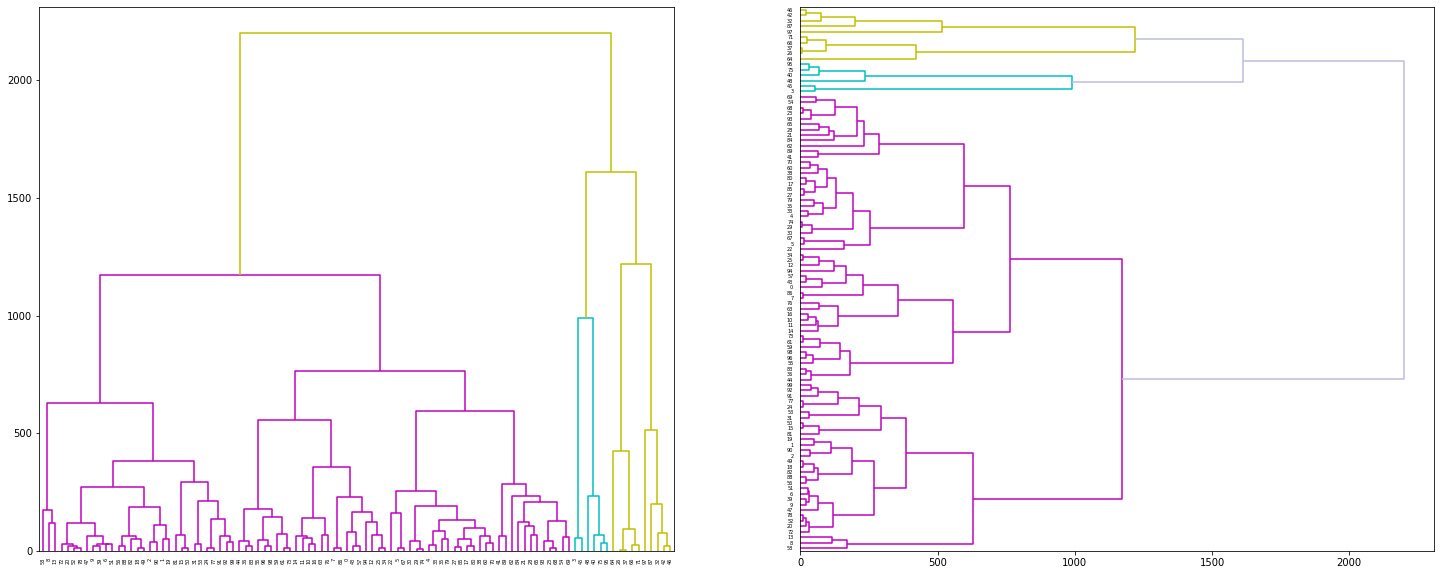

In [99]:
set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
dn1 = dendrogram(our_clusters, ax=axes[0], above_threshold_color='y', orientation='top')
dn2 = dendrogram(our_clusters, ax=axes[1], above_threshold_color='#bcbddc', orientation='right')
plt.savefig('dendrogram', dpi=500, orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

set_link_color_palette(None)  # reset to default after use
plt.show()

### Пункт 3
Пусть узлы разбиты на k кластеров.

a. Найти расположение центра масс (центроида) для каждого кластера;

b. Построить дерево кратчайших путей от объекта до центроидов.

c. Для каждого кластера построить дерево кратчайших путей от центроида до
всех вершин кластера.

d. Найти длину построенного дерева и сумму кратчайших расстояний от
объекта до всех заданных узлов.

In [0]:
from scipy.cluster.hierarchy import fcluster

In [0]:
k = 3
clusters = fcluster(our_clusters, k, criterion='maxclust')

In [165]:
clusters

array([2, 1, 1, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2,
       2, 2, 1, 2, 4, 2, 2, 2, 2, 1, 5, 2, 2, 2, 2, 4, 2, 1, 3, 2, 5, 2,
       2, 3, 5, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 4, 2,
       4, 2, 2, 2, 2, 4, 1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 5,
       1, 2, 1, 1, 1, 2, 2, 3, 2, 5, 2, 1], dtype=int32)

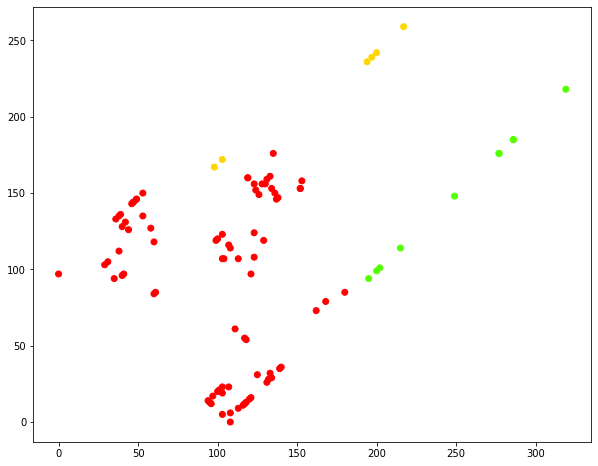

In [193]:
plt.figure(figsize=(10, 8))
plt.scatter(path_matrix[:,0], path_matrix[:,1], c=clusters, cmap='prism')
plt.show()

Ищем центроиды

In [0]:
def euclidean_dist(x1, y1, x2, y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def get_clustroid(cluster):
    mean = np.mean(cluster, axis=0)
    clustroid = np.argmin([euclidean_dist(*mean, x, y) for x, y in cluster])
    return clustroid

In [191]:
centroids = []
for cluster in our_clusters:  
  print(cluster)  

print(centroids)

[26.         37.          4.47213595  2.        ]
[29.         74.          7.21110255  2.        ]
[25.        34.         9.8488578  2.       ]
[52.         78.          9.89949494  2.        ]
[ 7. 86. 10.  2.]
[15. 50. 10.  2.]
[18. 49. 10.  2.]
[23. 68. 10.  2.]
[24. 77. 10.  2.]
[61. 73. 10.  2.]
[ 5.         67.         12.64911064  2.        ]
[27.         85.         14.69693846  2.        ]
[ 20.        103.         19.4422221   3.       ]
[43.         57.         19.74841766  2.        ]
[42.         46.         19.84943324  2.        ]
[ 9.         39.         19.89974874  2.        ]
[17.         80.         19.92485885  2.        ]
[56. 88. 20.  2.]
[36. 83. 20.  2.]
[96.         98.         21.54065923  2.        ]
[66.         71.         23.10844002  2.        ]
[ 4.         33.         26.62705391  2.        ]
[ 6.        51.        27.5317998  2.       ]
[10.        16.        28.7923601  2.       ]
[ 72.         112.          29.86636905   4.        ]
[31. 53. 30.  